In [1]:
import pandas as pd
import torch
import torch.nn as nn
import cv2
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from my_utils import *
import albumentations as A
import copy
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
from PSNR_SSIM import *
import timm
from my_utils import plot_durations
import warnings
import os
from imblearn.over_sampling import SMOTE
from collections import Counter
warnings.filterwarnings("ignore")
from model_list.model import NetworkNvidia
import torchvision.transforms as T
import carla
import torch.optim as optim
from carla import ColorConverter as cc
from env.env import CarlaEnv
from scipy import ndimage
from env import routes
import os
import torch
import numpy as np
from torch.distributions.normal import Normal
from distutils.util import strtobool
import argparse
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import queue
import glob
import collections
import datetime
import logging
import os
import math
import sys
import torch
from PIL import Image
import re
import weakref
import cv2
from custom_featrue_squeezing import squeezing
from torch.utils.tensorboard import SummaryWriter
from carla_agents.navigation.basic_agent import BasicAgent
from carla_agents.navigation.local_planner import RoadOption
from carla_agents.navigation.global_route_planner import GlobalRoutePlanner
from albumentations.pytorch.transforms import ToTensorV2
from carla_agents.navigation.local_planner import RoadOption
from GZ_UDnCNN import *
try:
    import pygame
    from pygame.locals import KMOD_CTRL
    from pygame.locals import KMOD_SHIFT
    from pygame.locals import K_0
    from pygame.locals import K_9
    from pygame.locals import K_BACKQUOTE
    from pygame.locals import K_BACKSPACE
    from pygame.locals import K_COMMA
    from pygame.locals import K_DOWN
    from pygame.locals import K_ESCAPE
    from pygame.locals import K_F1
    from pygame.locals import K_LEFT
    from pygame.locals import K_PERIOD
    from pygame.locals import K_RIGHT
    from pygame.locals import K_SLASH
    from pygame.locals import K_SPACE
    from pygame.locals import K_TAB
    from pygame.locals import K_UP
    from pygame.locals import K_a
    from pygame.locals import K_c
    from pygame.locals import K_g
    from pygame.locals import K_d
    from pygame.locals import K_h
    from pygame.locals import K_m
    from pygame.locals import K_n
    from pygame.locals import K_p
    from pygame.locals import K_q
    from pygame.locals import K_r
    from pygame.locals import K_s
    from pygame.locals import K_w
    from pygame.locals import K_l
    from pygame.locals import K_i
    from pygame.locals import K_z
    from pygame.locals import K_x
    from pygame.locals import K_MINUS
    from pygame.locals import K_EQUALS
except ImportError:
    raise RuntimeError('cannot import pygame, make sure pygame package is installed')

try:
    import numpy as np
except ImportError:
    raise RuntimeError('cannot import numpy, make sure numpy package is installed')
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)

c:\Users\user\anaconda3\envs\carla\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
seed = 2024
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
CFG={
    'device': torch.device('cuda' if torch.cuda.is_available() else "cpu"),
    'EPOCH':1000,
    'BATCH_SIZE':1,
	'target':0.3,
	'host':'127.0.0.1',
    'port': 2000,
    'map':'Town05',
	'seed':2024,
	'branched':True,
    'on_test_set':True,
	'generate_saliency':False,
    'deterministic':True,
    
}

In [3]:
#expert_states_train=np.load('./save_data/norm_steering_expert_states_5cut_400_round3_v5.npy')
#expert_actions_train=np.load('./save_data/norm_steering_expert_action_5cut_400_round3_v5.npy')
#expert_speeds_train=np.load('./save_data/norm_steering_expert_speed_5cut_400_round3_v5.npy')
#expert_commands_train=np.load('./save_data/norm_steering_expert_command_5cut_400_round3_v5.npy')

expert_states_val=np.load('./save_data/expert_states_val.npy')
expert_actions_val=np.load('./save_data/expert_actions_val.npy')
expert_speeds_val=np.load('./save_data/expert_speeds_val.npy')
expert_commands_val=np.load('./save_data/expert_commands_val.npy')

In [4]:

class BaseModel(nn.Module):
    def __init__(self,model_name,class_number=1):
        super(BaseModel,self).__init__()
        
        self.conv1=nn.Conv2d(9,3,kernel_size=3,stride=1,padding=1)
        self.batch_norm=nn.BatchNorm2d(3)
        self.relu=nn.ReLU()
        self.basemodel=timm.create_model(model_name,pretrained=False,num_classes=512)
        self.tanh=nn.Tanh()
        self.dropout=nn.Dropout(0.3)


        ###############Mesaurement###############

        self.measure_fc1=nn.Linear(1,128)
        self.measure_fc2=nn.Linear(128,128)
        self.measure_fc3=nn.Linear(128,128)

        self.steering_branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512 + 128, 256),
                nn.Tanh(),
                nn.Dropout(0.3),
                nn.Linear(256, 256),
                nn.Tanh(),
                nn.Dropout(0.3),
                nn.Linear(256, class_number)
            ) for _ in range(3)  # 3개의 브랜치로 수정
        ])

        self.throttle_branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(512 + 128, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, class_number)

            ) for _ in range(3)  # 3개의 브랜치로 수정
        ])

        

       
        
    def forward(self,input,speed,command):
        
        x=self.conv1(input)
        x=self.batch_norm(x)
        x=self.relu(x)

        x=self.basemodel(x)

        s=self.dropout(self.relu(self.measure_fc1(speed)))
        s=self.dropout(self.relu(self.measure_fc2(s)))
        s=self.dropout(self.relu(self.measure_fc3(s)))
       
        input_cat=torch.cat((x,s),dim=-1)
        branch_idx = torch.argmax(command, dim=1)
        #print(branch_idx)

        steering = torch.zeros((input.size(0), 1)).to(input.device)
        throttle = torch.zeros((input.size(0), 1)).to(input.device)

        for i in range(input.size(0)):  # batch 내의 각 샘플에 대해 적절한 branch 선택
            steering[i] = self.steering_branches[branch_idx[i]](input_cat[i].unsqueeze(0))
            steering_dist =self.steering_branches[branch_idx[i]][:5](input_cat[i].unsqueeze(0))
            throttle[i] = self.throttle_branches[branch_idx[i]](input_cat[i].unsqueeze(0))
            throttle_dist = self.throttle_branches[branch_idx[i]][:5](input_cat[i].unsqueeze(0))
            dist=torch.cat((steering_dist,throttle_dist),dim=-1)
        
        

    
        return throttle, steering,steering_dist,throttle_dist
       

In [5]:
import torchvision
class RandomTranslate(object):
    def __call__(self, image, steering_angle, range_x=80, range_y=20):

        trans_x = range_x * (np.random.rand() - 0.5)
        trans_y = range_y * (np.random.rand() - 0.5)
        
        #steering_angle += trans_x * 0.002
        #trans_m = torch.tensor([[1, 0, trans_x], [0, 1, trans_y]])
        #height, width = image.shape[1], image.shape[2]
        affine_transform = T.functional.affine(image, angle=0, translate=(trans_x, trans_y), scale=1.0, shear=[0, 0])
        return affine_transform, steering_angle
class RandFlip(object):
    
    def __call__(self, image,action):
        if random.randint(0, 1) == 1:
            image = torch.flip(image, [-1])  
            action = -action
        
        return image,action
    
class RandBrightness(object):

    def __call__(self, image,mode):
        img = image# 이미지를 [H, W, C]에서 [C, H, W]로 변환
    
            
        if mode=='channel_9' or mode=='concat':
            num=random.randint(0,3)
            if num==0:
                img[:3,:,:] = torchvision.transforms.functional.adjust_brightness(img[:3,:,:], 1 + np.random.uniform(-0.5, 0.5))
            elif num==1:
                
                img[3:6,:,:] = torchvision.transforms.functional.adjust_brightness(img[3:6,:,:], 1 + np.random.uniform(-0.5, 0.5))
            elif num==2:
                
                img[6:,:,:] = torchvision.transforms.functional.adjust_brightness(img[6:,:,:], 1 + np.random.uniform(-0.5, 0.5))
            img=torch.clamp(img,min=0,max=1)
        return img
class RandRotateView(object):
    def __call__(self, image,action,target_mode):
        if random.randint(0, 3) == 1 and abs(action) < 0.3:
            rotate = random.uniform(-30, 30)
            delta_angle = rotate / 60
            image = torchvision.transforms.functional.rotate(image, rotate)  # ndimage.rotate 대신 torchvision의 rotate 사용

            if target_mode == 'steer':
                action += delta_angle
        return image, action
    
class RandRotation(object):
    def __call__(self, image):
        rotate = random.uniform(-1, 1)
        image = torchvision.transforms.functional.rotate(image, rotate)
        image = torch.clip(image, 0, 1)
        return image

class CustomDataset(Dataset):
    def __init__(self, image, action,speed,command,transforms=None,mode='center',target_mode='steer',train_mode=True):
        self.image = image
        self.action = action
        self.command=command
        self.transforms = transforms
        self.mode=mode
        self.target_mode=target_mode
        self.train_mode=train_mode
        self.speed=torch.FloatTensor(speed)
        self.RandFlip=RandFlip()
        self.RandBrightness=RandBrightness()
        self.RandRotation=RandRotation()
        self.RandRotateView=RandRotateView()
        self.RandomTranslate=RandomTranslate()
        #self.resize=torchvision.transforms.Resize((320,320))

    def __getitem__(self, index):
        image=self.image[index].transpose(1,2,0)/255.
        image=image[22:,:,:]
        if self.target_mode=='steer':
            label=self.action[index][1]
            label=np.round(label,3)
            label=torch.FloatTensor([label])
            throttle=self.action[index][0]
            throttle=torch.FloatTensor([throttle])
            command=torch.FloatTensor(self.command[index])
        # elif self.target_mode=='throttle':
        elif self.target_mode=='breake':
            label=self.action[index][2]

            label=torch.FloatTensor([label])
        # left=image[:,:,:3]
        # center=image[:,:,3:6]
        # right=image[:,:,6:]
        
        
        if self.mode=='center':
            center=image[:,:,3:6]

            concat_image=center
            if self.train_mode==True:
                concat_image,label=self.RandFlip(concat_image,label)
                concat_image=self.RandBrightness(concat_image,self.mode)
                concat_image=self.RandRotation(concat_image,)
                concat_image,label=self.RandRotateView(concat_image,label,self.target_mode)
        elif self.mode=='channel_9' or self.mode=='concat':
            if self.train_mode==True:
                image = self.transforms(image=image)['image']
                image,label=self.RandFlip(image,label)
                image=self.RandBrightness(image,self.mode)
                image=self.RandRotation(image)
                image,label=self.RandRotateView(image,label,self.target_mode)
                image,label=self.RandomTranslate(image,label)
                #image=self.resize(image)
            elif self.train_mode==False:
                image = self.transforms(image=image)['image']

                # print(label)
                #image=self.resize(image)
            

        

        if self.transforms is not None:
            if self.mode=='total':
                
                if self.train_mode==True:
                    image = self.transforms(image=image)['image']
                    image=torch.cat((image[:3,:,:],image[3:6,:,:],image[6:,:,:]),dim=-1)
                    
                   
                    image,label=self.RandFlip(image,label)
                    image=self.RandBrightness(image,self.mode)
                    image=self.RandRotation(image)
                    image,label=self.RandRotateView(image,label,self.target_mode)
                    #image=self.resize(image)
                    

                elif self.train_mode==False:
                    #label=label-steering_min/steering_max-steering_min
                    image = self.transforms(image=image)['image']
                    image=torch.cat((image[:3,:,:],image[3:6,:,:],image[6:,:,:]),dim=-1)
                    #image=self.resize(image)
                    

        
        if self.action is not None:
            s=self.speed[index]
            image=image
            steering=torch.round(label * 1000) / 1000 #4자리수에서 올림
            label=torch.cat((throttle,steering),dim=-1)

            return image,s,command,label
        else:
            return image
    
    def __len__(self):
        return len(self.image)

jpg to mp4

In [ ]:
env = CarlaEnv(world=CFG['map'],evaluate=True, on_test_set=CFG['on_test_set'])
num_routes = len(routes.town_5_test_spawns)
print(num_routes)
model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/601_resnet18_channel_9_steer_0.002256.pt').to(CFG['device'])

In [11]:
test_transform=A.Compose([
    ToTensorV2()
])
model.eval()
# throttle=torch.tensor([0.4]).unsqueeze(0).to(CFG['device'])
action_breake=torch.tensor([0.0]).unsqueeze(0).to(CFG['device'])
for i in tqdm(range(num_routes)):# num_routes
    done = False
    obs, command, speed = env.reset(route=i)
    while not done:
        obs=obs.transpose(1,2,0)/255.
        obs=obs[22:,:,:]
        image = test_transform(image=obs)['image']
        #image=torch.FloatTensor(image)
        image=image.to(CFG['device']).unsqueeze(0).float()
        speed = torch.tensor([speed], dtype=torch.float).to(CFG['device']).unsqueeze(0)
        command=torch.tensor(command).unsqueeze(0).float().to(CFG['device'])
        throttle,steering,_,_=model(image,speed,command)
        action=torch.cat((throttle,steering,action_breake),dim=-1)[0] #throttle,steering
        action = action.clone().detach()
        next_obs, command, speed, _, done, info = env.step(action.view(-1).cpu().numpy())
        obs = next_obs
        
        if done:
            print(f'route {i:02}: {info}')
    #     break
    # break

NameError: name 'model' is not defined

In [ ]:
# plt.figure(figsize=(20,10))
# plt.subplot(1,3,1)
# plt.imshow(image[0][:3].cpu().permute(1,2,0))
# plt.subplot(1,3,2)
# plt.imshow(image[0][3:6].cpu().permute(1,2,0))
# plt.subplot(1,3,3)
# plt.imshow(image[0][6:].cpu().permute(1,2,0))

# 적대적 공격 수행

In [6]:

train_transform=A.Compose([
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  
    ToTensorV2()
])
test_transform=A.Compose([
    #A.Resize(320,320),
   
    ToTensorV2()
])
target_label_mode='steer'
camera_view='channel_9' #channel_9, total,center,concat
#train_transform_dataset=CustomDataset(expert_states_train,expert_actions_train,expert_speeds_train,expert_commands_train,train_transform,mode=camera_view,target_mode=target_label_mode,train_mode=True)
val_transform_dataset=CustomDataset(expert_states_val,expert_actions_val,expert_speeds_val,expert_commands_val,test_transform,mode=camera_view,target_mode=target_label_mode,train_mode=False)
#train_loader=DataLoader(train_transform_dataset,batch_size=CFG['BATCH_SIZE'],shuffle=True)
test_loader=DataLoader(val_transform_dataset,batch_size=1,shuffle=False)

In [25]:



def convert_array_sign(input_tensor):
    return torch.sign(input_tensor)


def grm(x, va):
    return (1 / va) * torch.cos(va * x + torch.pi / 2) + x
    #return torch.sin(x *va * math.pi + math.pi) + x

def grm_derivative(x, va):
    return 1 - torch.sin(va * x + torch.pi / 2)
    #return 1+va*math.pi*torch.cos(x*va+math.pi)




def get_cw_grad(adv, image,speed,command, target_point,target ,model):
    y_adv_throttle,y_adv_steering,_,_= model(adv,speed,command)
    y_throttle,y_steering,_,_= model(image,speed,command)
    
    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target

    if target_point=='throttle':
        loss_y = F.mse_loss(y_adv_throttle, y_target)
    elif target_point=='steering':
        loss_y = F.mse_loss(y_adv_steering, y_target)
    else:
        loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
        loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
        loss_y=loss_y_throttle*0.4+loss_y_steering*0.6
    l2 = nn.MSELoss()
    loss=loss_y+ l2(torch.tensor([0.0]).to(device), image - adv) / l2(torch.tensor([0.0]).to(device), image)


    y_adv_t=y_adv_throttle.item()-y_throttle.item()
    y_adv_s=y_adv_steering.item()-y_steering.item()
    diff = (y_adv_t+y_adv_s)#/2
        
    loss.backward()
    ret = adv.grad.clone()
    
    model.zero_grad()
    adv.grad.data.zero_()
    #image.grad.data.zero_()
    return ret,diff
 

def BPDA(target_model,target,image,speed,command,target_point,iterations,gradient_removal_mode,device):
    image=image.clone().detach().to(device)
    speed=speed.clone().detach().to(device)
    command=command.clone().detach().to(device)

    adv_images =image.clone().detach()
    adv_images.requires_grad_()
    for _ in range(iterations):
        adv_def=adv_images.detach().clone()
        adv_def.requires_grad_()
        l2 = nn.MSELoss()
        loss = l2(torch.tensor([0.0]).to(device), adv_def)
        loss.backward()
        g,diff = get_cw_grad(adv_def, image,speed,command,target_point, target,target_model)

        if gradient_removal_mode==True:
            grm_grad=grm_derivative(adv_images,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=g*torch.sum(grad_sign)
        else:
            g=g
        adv_images = adv_images.detach() - 1 * g
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()
        adv_images.requires_grad_()

        if abs(diff)>0.3:
            break
    return adv_images.detach()




def CW(target_model,target,image,speed,command,target_point,c,device,gradient_removal_mode,lr=0.01):
    def atanh(x):
        return 0.5 * torch.log((1 + x) / (1 - x))
    def tanh_space(x):
        return 1 / 2 * (torch.tanh(x) + 1)
    def inverse_tanh_space(x):
        return atanh(torch.clamp(x * 2 - 1, min=-1, max=1))
    
    image=image.clone().detach().to(device)
    speed=speed.clone().detach().to(device)
    command=command.clone().detach().to(device)

    w = inverse_tanh_space(image).detach()
    w.requires_grad=True
    #print(image)
    y_throttle,y_steering,_,_=target_model(image,speed,command)
    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target

    #

    best_adv_images =image.clone().detach()
    adv_speed = speed.clone().detach()
    adv_command = command.clone().detach()
    best_L2 = 1e10 * torch.ones((len(image))).to(device)
    prev_cost = 1e10
    dim = len(image.shape)
    MSELoss = nn.MSELoss(reduction="none")
    Flatten = nn.Flatten()
    optimizer = optim.Adam([w], lr=lr)

    for step in range(50):
        optimizer.zero_grad()
        adv_images = tanh_space(w)

        current_L2 = MSELoss(Flatten(adv_images), Flatten(image)).sum(dim=1)
        L2_loss = current_L2.sum()
        y_adv_throttle,y_adv_steering,_,_=target_model(adv_images,adv_speed,adv_command)

        if target_point=='throttle':
            loss_y = F.mse_loss(y_adv_throttle, y_target)
        elif target_point=='steering':
            loss_y = F.mse_loss(y_adv_steering, y_target)
        else:
            loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
            loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
            loss_y=loss_y_throttle*0.4+loss_y_steering*0.6

        cost = L2_loss + c * loss_y

        if gradient_removal_mode==True:
            grm_grad=grm_derivative(adv_images,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=cost*torch.sum(grad_sign)
        else:
            g=cost
        
        
        
        
        g.backward(retain_graph=True)
        optimizer.step()
        if target_point=='throttle':
            diff = (y_adv_throttle.item()-y_throttle.item())
        elif target_point=='steering':
            diff = (y_adv_steering.item()-y_steering.item())
        else:
            diff=(y_adv_throttle.item()-y_throttle.item())+(y_adv_steering.item()-y_steering.item())
        if abs(diff) >= abs(target):
            condition=torch.tensor([1.0]).to(device)
        else:
            condition=torch.tensor([0.0]).to(device)
        mask = condition * (best_L2 > current_L2.detach())
        best_L2 = mask * current_L2.detach() + (1 - mask) * best_L2
        mask = mask.view([-1] + [1] * (dim - 1))
        best_adv_images = mask * adv_images.detach() + (1 - mask) * best_adv_images

        if step % max(50 // 10, 1) == 0:
            if cost.item() > prev_cost:
                return best_adv_images
            prev_cost = cost.item()

    return best_adv_images

    
    



def PGD(target_model,target,image,speed,command,target_point,epsilon,gradient_removal_mode,device):
    image=image.clone().detach().to(device)
    speed=speed.clone().detach().to(device)
    command=command.clone().detach().to(device)
    y_throttle,y_steering,_,_=target_model(image,speed,command)

    adv_image =image.clone().detach()
    adv_speed = speed.clone().detach()
    adv_command = command.clone().detach()

    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target

    for _ in range(5):
        adv_image.requires_grad=True
        y_adv_throttle,y_adv_steering,_,_=target_model(adv_image,adv_speed,adv_command)

        if target_point=='throttle':
            loss_y = F.mse_loss(y_adv_throttle, y_target)
        elif target_point=='steering':
            loss_y = F.mse_loss(y_adv_steering, y_target)
        else:
            loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
            loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
            loss_y=loss_y_throttle*0.4+loss_y_steering*0.6

        grad = torch.autograd.grad(
                loss_y, adv_image, retain_graph=False, create_graph=False
            )[0]
        
        if gradient_removal_mode==True:
            grm_grad=grm_derivative(adv_image,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=grad.sign()*grad_sign
        else:
            g=grad.sign()
        
        adv_image = adv_image.detach() + (2/255) * g
        delta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()
    return adv_image



def MI_FGSM(target_model,target,image,speed,command,target_point,epsilon,gradient_removal_mode,device):


 
    image=image.clone().detach().to(device)
    speed=speed.clone().detach().to(device)
    command=command.clone().detach().to(device)

    y_throttle,y_steering,_,_=target_model(image,speed,command)

    momentum = torch.zeros_like(image).detach().to(device)
    
    


    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target

    adv_image =image.clone().detach()
    adv_speed = speed.clone().detach()
    adv_command = command.clone().detach()

    for _ in range(5):
        adv_image.requires_grad = True
        
        y_adv_throttle,y_adv_steering,_,_=target_model(adv_image,adv_speed,adv_command)

        if target_point=='throttle':
            loss_y = F.mse_loss(y_adv_throttle, y_target)
        elif target_point=='steering':
            loss_y = F.mse_loss(y_adv_steering, y_target)
        else:
            loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
            loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
            loss_y=loss_y_throttle*0.4+loss_y_steering*0.6

        


        grad = torch.autograd.grad(
                loss_y, adv_image, retain_graph=False, create_graph=False
            )[0]
        
       
        #print(grad)
        grad = grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
        grad = grad + momentum
        momentum=grad

        if gradient_removal_mode==True:
            grm_grad=grm_derivative(adv_image,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=grad.sign()*grad_sign
        else:
            g=grad_sign()

        adv_image = adv_image.detach() + (2/255) * g

        delta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()

        
    return adv_image

def I_FGSM(target_model,target,image,speed,command,target_point,epsilon,gradient_removal_mode,device):
    image=image.clone().detach().to(device)
    speed=speed.clone().detach().to(device)
    command=command.clone().detach().to(device)
    
    y_throttle,y_steering,_,_=target_model(image,speed,command)
    


    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target

    ori_image =image.clone().detach()
    ori_speed = speed.clone().detach()
    ori_command = command.clone().detach()

    for _ in range(5):
        image.requires_grad=True
       
 

        y_throttle,y_steering,_,_=target_model(image,speed,command)
        y_adv_throttle=y_throttle
        y_adv_steering=y_steering
        if target_point=='throttle':
            loss_y = F.mse_loss(y_adv_throttle, y_target)
        elif target_point=='steering':
            loss_y = F.mse_loss(y_adv_steering, y_target)
        else:
            loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
            loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
            loss_y=loss_y_throttle*0.4+loss_y_steering*0.6
            #print(loss_y)
        grad = torch.autograd.grad(
                loss_y, image, retain_graph=False, create_graph=False
            )[0]
        
        if gradient_removal_mode==True:
            grm_grad=grm_derivative(image,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=grad.sign()*grad_sign
        else:
            g=grad.sign()
    
        
       

        adv_images = image + (2/255)* g
        
        a = torch.clamp(ori_image - epsilon, min=0)
        b = (adv_images >= a).float() * adv_images + (
                adv_images < a
            ).float() * a  # nopep8
        c = (b > ori_image + epsilon).float() * (ori_image + epsilon) + (
                b <= ori_image + epsilon
            ).float() * b  # nopep8
        image = torch.clamp(c, max=1).detach()
    return image



def optimized_attack(target_model,target,image,speed,command,target_point,gradient_removal_mode,device):

    y_throttle,y_steering,_,_=target_model(image,speed,command)

    y_adv_throttle=y_throttle
    y_adv_steering=y_steering

    if target_point=='throttle':
        y_target=y_throttle+target
    elif target_point=='steering':
        y_target=y_steering+target
    else:
        y_throttle_target=y_throttle+target
        y_steering_target=y_steering+target


    perturb = torch.zeros_like(image)
    perturb.requires_grad = True
    perturb = perturb.to(device)
    optimizer = optim.Adam(params=[perturb], lr=0.005)
    diff = 0
    # while abs(diff) < abs(target):
    for i in range(50):
        perturbed_image = image + perturb
        
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        y_adv_throttle,y_adv_steering,_,_ = target_model(perturbed_image,speed,command)
        optimizer.zero_grad()

        if target_point=='throttle':
            loss_y = F.mse_loss(y_adv_throttle, y_target)
        elif target_point=='steering':
            loss_y = F.mse_loss(y_adv_steering, y_target)
        else:
            loss_y_throttle= F.mse_loss(y_adv_throttle, y_throttle_target)
            loss_y_steering = F.mse_loss(y_adv_steering, y_steering_target)
            loss_y=loss_y_throttle*0.4+loss_y_steering*0.6
            
        loss_n = torch.mean(torch.pow(perturb, 2))
        loss_adv = loss_y + loss_n

        if gradient_removal_mode==True:
            grm_grad=grm_derivative(perturbed_image,va=510*torch.pi)
            grad_sign=convert_array_sign(grm_grad)
            g=loss_adv*torch.sum(grad_sign)
        else:
            g=loss_adv


        g.backward(retain_graph=True)
        optimizer.step()

        if target_point=='throttle':
            y_adv=y_adv_throttle
            diff = y_adv.item()-y_throttle.item()
        elif target_point=='steering':
            y_adv=y_adv_steering
            diff = y_adv.item()-y_steering.item()
        else:
            y_adv_t=y_adv_throttle.item()-y_throttle.item()
            y_adv_s=y_adv_steering.item()-y_steering.item()
            diff = (y_adv_t+y_adv_s)#/2
        if abs(diff) >= abs(target):
            break
        # print(diff, target)
    return perturbed_image.detach(), perturb, y_throttle,y_steering, y_adv_throttle,y_adv_steering
    
    

In [26]:
from autoencoder import *


# udncnn=DnCNN(D=8).to(CFG['device'])
# GZ_udncnn=Gradient_Zero(model=udncnn).to(CFG['device'])
#GZ_dncnn=torch.load('F:/VSC/graduate_for_simulator/model_list/EPOCH_110_0.002329670154664879_GZ_DnCNN.pt').to(CFG['device'])

model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/601_resnet18_channel_9_steer_0.002256.pt').to(CFG['device'])
#victim_model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/601_resnet18_channel_9_steer_0.002256.pt').to(CFG['device'])
#model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/advtraining_841_resnet18_channel_9_steer_0.002322.pt').to(CFG['device'])

#model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/901_mobilenetv2_100_channel_9_steer_0.002354.pt').to(CFG['device'])
#victim_model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/901_mobilenetv2_100_channel_9_steer_0.002354.pt').to(CFG['device'])
#model=torch.load('F:/VSC/graduate_for_simulator/model_list/best_model/advtraining_591_mobilenetv2_100_channel_9_steer_0.002410.pt').to(CFG['device'])

#model=torch.load('./model_list/best_model/61_vgg16_channel_9_steer_0.002720.pt').to(CFG['device'])
#model=torch.load('./model_list/best_model/advtraining_141_vgg16_channel_9_steer_0.002274.pt').to(CFG['device'])
#original_model=copy.deepcopy(model)

class gradient_inverse_model(nn.Module):
    def __init__(self,model,n):
        super(gradient_inverse_model,self).__init__()
        self.model=model
        self.n=n
        
    def forward(self, x,speeds,command):
    

        with torch.no_grad():
            x_t = torch.clamp(torch.round(x * 255), 0, 255) / 255
            T = x_t - x
        x = T + x
        x = torch.sin(x * self.n * math.pi + math.pi) + x
    
        throttle,steering,_,_ = self.model(x,speeds,command)
        return throttle,steering,_,_
    
class gradient_removal_model(nn.Module):
    def __init__(self,model,n):
        super(gradient_removal_model,self).__init__()
        self.model=model
        self.n=n
        
    def forward(self, x,speeds,command):
    

        #with torch.no_grad():
        #x=grm(x,self.n*torch.pi)
        throttle,steering,_,_ = self.model(x,speeds,command)
        return throttle,steering,_,_
    

def median_filter_2d(x, kernel_size=2):
    # 커널 크기에 맞게 패딩
    pad_size = kernel_size // 2
    x_padded = F.pad(x, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
    
    # 패치별로 미디언 계산
    unfolded = x_padded.unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)
    median_filtered, _ = unfolded.contiguous().view(*unfolded.size()[:4], -1).median(dim=-1)
    return median_filtered    

class feature_squeezing_model(nn.Module):
    def __init__(self,model):
        super(feature_squeezing_model,self).__init__()
        self.model=model

    def forward(self,x,speeds,command):

       
        x=median_filter_2d(x, kernel_size=2)
        squeeze_image_tensor =x
        squeeze_image_tensor = squeeze_image_tensor.type(torch.FloatTensor)
        squeeze_image_tensor = squeeze_image_tensor.to(CFG['device'])

        throttle,steering,_,_ = self.model(squeeze_image_tensor,speeds,command)
        return throttle,steering,_,_
    
class GELU_Autoencoder_model(nn.Module):
    def __init__(self,model,GELU_AE_m):
        super(GELU_Autoencoder_model,self).__init__()
        self.model=model
        self.GELU_AE_m=GELU_AE_m
    def forward(self,x,speeds,command):

        x=self.GELU_AE_m(x)
        throttle,steering,_,_ = self.model(x,speeds,command)
        return throttle,steering,_,_

number=510
squeezing_model=feature_squeezing_model(model).to(device)
gradient_model=gradient_inverse_model(model,n=number).to(device)
gradient__removal_model=gradient_removal_model(model,n=number).to(device)
# concat_model=Concat_model(GZ_dncnn,copy.deepcopy(model)).to(CFG['device'])
# GELU_AE_model=GELU_Autoencoder_model(copy.deepcopy(model),GELU_AE).to(CFG['device'])


In [27]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

steering_label_list=[]
throttle_label_list=[]
def RMSE(pred,label):
    c=nn.MSELoss().to(CFG['device'])
    loss=torch.sqrt(c(pred,label))
    return loss

test_loss_MAE=[]
test_loss_MSE=[]
test_loss_RMSE=[]

mse_criterion=nn.MSELoss().to(CFG['device'])
mae_criterion=nn.L1Loss().to(CFG['device'])
real_label=[]
predict_adv_label=[]
predict_label=[]
times = []
peak_memories = []
total_diff = np.array([])
attack_method='PGD'#opt, MI-FGSM, I-FGSM,PGD,CW,None,#BPDA,EOT_PGD
attack_point=2 #0: throttle 1: steering 2: throttle&steering


Transfer_attack=False

feature_squeezing_flag=False

gradient_inverse_mode=False

grm_mode=True


CONCAT=False


print('=============================')
if Transfer_attack==False:
    print('Transfer Attack OFF')
else:
    print('Transfer Attack ON')
print("Attack_METHOD: ",attack_method)
if attack_point==0:
    print("attack point: throttle")
elif attack_point==1:
    print("attack point: steering")
else:
    print("attack point: throttle&steering")

if feature_squeezing_flag==True:
    print("feature squeezing mode on")
else:
    print("feature squeezing mode off")

if grm_mode==True:
    print("grm_model ON")
else:
    print("grm_model OFF")

if gradient_inverse_mode==False:
    print('gradient_mod OFF')
else:
    print('gradient_mod ON')
if CONCAT==True:
    print("CONCAT ON")
else:
    print("CONCAT OFF")

print('=============================')


if Transfer_attack==True:

    if gradient_mode==True:
        t_model=gradient_model.eval()
        main_model=victim_model.eval()
    elif CONCAT==True:
        t_model=concat_model.eval()
        main_model=victim_model.eval()

    elif feature_squeezing_flag==True:

        t_model=squeezing_model.eval()
        main_model=victim_model.eval()
    else:
        t_model=model.eval()
        main_model=victim_model.eval()
else:
    if gradient_inverse_mode==True:
        main_model=gradient_model.eval()
        t_model=gradient_model.eval()
    elif CONCAT==True:
        t_model=concat_model.eval()
        main_model=concat_model.eval()

    elif feature_squeezing_flag==True:
        t_model=squeezing_model.eval()
        main_model=squeezing_model.eval()

    elif grm_mode==True:
        main_model=gradient__removal_model.eval()
        t_model=gradient__removal_model.eval()
   
    else:
        main_model=model.eval()
        t_model=model.eval()







if attack_point==0:
    target_point='throttle'
elif attack_point==1:
    target_point='steering'
elif attack_point==2:
    target_point='throttle&steering'
for i,(test_image,test_speed,test_command,test_label) in enumerate(tqdm(test_loader)):
    
    test_img=test_image.to(CFG['device'])
    test_speeds=test_speed.to(CFG['device'])
    test_labels=test_label.to(CFG['device'])
    ### 진짜 라벨 저장######
    real_label.append(test_labels[0][1].cpu().detach())
    
    test_command=test_command.to(CFG['device'])
    #print(test_labels[0][1])

    if attack_method=='opt':
        perturbed_image, perturb, y_throttle,y_steering, y_adv_throttle,y_adv_steering=optimized_attack(target_model=main_model,
                                                                                                        target=CFG['target'],
                                                                                                        image=test_img,
                                                                                                        speed=test_speeds,
                                                                                                        command=test_command,
                                                                                                        target_point=target_point,
                                                                                                        gradient_removal_mode=grm_mode,
                                                                                                        device=CFG['device'])
    
    elif attack_method=='I-FGSM':
        perturbed_image=I_FGSM(target_model=main_model,
                                target=CFG['target'],
                                image=test_img,
                                speed=test_speeds,
                                command=test_command,
                                target_point=target_point,
                                epsilon=8/255,
                                gradient_removal_mode=grm_mode,
                                device=CFG['device'])
    elif attack_method=='MI-FGSM':
        perturbed_image=MI_FGSM(target_model=main_model,
                                target=CFG['target'],
                                image=test_img,
                                speed=test_speeds,
                                command=test_command,
                                target_point=target_point,
                                epsilon=8/255,
                                gradient_removal_mode=grm_mode,
                                device=CFG['device'])
    elif attack_method=='PGD':
        perturbed_image=PGD(target_model=main_model,
                                target=CFG['target'],
                                image=test_img,
                                speed=test_speeds,
                                command=test_command,
                                target_point=target_point,
                                epsilon=8/255,
                                gradient_removal_mode=grm_mode,
                                device=CFG['device'])
    elif attack_method=='CW':
        perturbed_image=CW(target_model=main_model,
                                target=CFG['target'],
                                image=test_img,
                                speed=test_speeds,
                                command=test_command,
                                target_point=target_point,
                                gradient_removal_mode=grm_mode,
                                c=1000,
                                
                                device=CFG['device'])
    elif attack_method=="BPDA":
        perturbed_image= BPDA(target_model=main_model,
                              target=CFG['target'],
                              image=test_img,
                              speed=test_speeds,
                              command=test_command,
                              target_point=target_point,
                              iterations=50,
                              gradient_removal_mode=grm_mode,
                              device=CFG['device'])
    else:
        perturbed_image=test_img

    torch.cuda.synchronize()
    start_time = time.time() 
    test_adv_output_throttle,test_adv_output_steering,_,_=t_model(perturbed_image,test_speeds,test_command) #어택
    end_time = time.time()
    torch.cuda.synchronize()  # 동기화
    elapsed_time = end_time - start_time
    peak_memory = torch.cuda.max_memory_allocated() / (1024**2)  # 최대 메모리(MB)
    times.append(elapsed_time)
    peak_memories.append(peak_memory)

    #perturbed_image=torch.clamp(perturbed_image+noise,0,1)
    #test_adv_output_throttle,test_adv_output_steering,_,_=t_model(perturbed_image+noise,test_speeds,test_command) #어택GI
   
    test_output_throttle,test_output_steering,_,_=t_model(test_img,test_speeds,test_command) #노말##
    
    throttle_diff = (test_adv_output_throttle -test_output_throttle).detach().cpu().numpy()
    steering_diff = (test_adv_output_steering - test_output_steering).detach().cpu().numpy()

    # if (torch.sum(perturbed_image.cpu().detach()-test_image.cpu().detach())!= 0):
    #     print("다름")


    diff = np.squeeze((steering_diff+throttle_diff))

    #print(perturbed_image-test_img)



    

    MSE_throttle_loss=mse_criterion(test_adv_output_throttle,test_labels[:,0].unsqueeze(1))
    MSE_steering_loss=mse_criterion(test_adv_output_steering,test_labels[:,1].unsqueeze(1))
    MSE_loss=(MSE_throttle_loss*0.4+MSE_steering_loss*0.6)
    test_loss_MSE.append(MSE_loss.item())


    

    MAE_throttle_loss=mae_criterion(test_adv_output_throttle,test_labels[:,0].unsqueeze(1))
    MAE_steering_loss=mae_criterion(test_adv_output_steering,test_labels[:,1].unsqueeze(1))
    MAE_loss=(MAE_throttle_loss*0.4+MAE_steering_loss*0.6)
    test_loss_MAE.append(MAE_loss.item())

    total_diff = np.concatenate((total_diff, [diff]))	


    predict_adv_label.append(test_adv_output_steering[0][0].cpu().detach()+test_adv_output_throttle[0][0].cpu().detach())
    predict_label.append(test_output_steering[0][0].cpu().detach()+test_output_throttle[0][0].cpu().detach())
    success_ = len(total_diff[abs(total_diff) >= CFG['target']])
    # steering_label_list.append()
    # throttle_label_list.append()
    
    
    if (i+0)%1000==0:
        print("공격 성공: ", success_/(i+1)*100)
        MSE_loss=np.mean(test_loss_MSE)
        MAE_loss=np.mean(test_loss_MAE)
       
       
        print("MSE: ",MSE_loss)
        print("MAE: ",MAE_loss)
        print("===================")
       

        
    # if i==10:
    #     break
        


print("=====================================================")      
  
MSE_loss=np.mean(test_loss_MSE)
MAE_loss=np.mean(test_loss_MAE)

print("진짜예측과 가짜 예측의 차이 평균: ", np.mean(total_diff))
print("최종 공격 성공: ", success_/(i+1)*100)

print("MSE: ",MSE_loss)
print("MAE: ",MAE_loss)
print("=====================================================")   

avg_time = sum(times) / len(times)
avg_memory = sum(peak_memories) / len(peak_memories)

# 결과 출력
print(f"Average Inference Time: {avg_time:.6f} seconds")
print(f"Average Peak Memory Usage: {avg_memory:.2f} MB")


Transfer Attack OFF
Attack_METHOD:  PGD
attack point: throttle&steering
feature squeezing mode off
grm_model ON
gradient_mod OFF
CONCAT OFF


  0%|          | 0/6739 [00:00<?, ?it/s]

  0%|          | 2/6739 [00:00<18:51,  5.95it/s]

공격 성공:  0.0
MSE:  9.836714889388531e-05
MAE:  0.00904882326722145


 15%|█▍        | 1004/6739 [00:57<05:21, 17.82it/s]

공격 성공:  0.0
MSE:  0.001130358092738113
MAE:  0.01929703355030311


 30%|██▉       | 2004/6739 [01:55<04:49, 16.36it/s]

공격 성공:  0.0
MSE:  0.0056141874852862934
MAE:  0.031547270437026737


 45%|████▍     | 3004/6739 [02:55<03:44, 16.65it/s]

공격 성공:  0.0
MSE:  0.004311970035963621
MAE:  0.028125400515057918


 59%|█████▉    | 4004/6739 [03:53<02:45, 16.51it/s]

공격 성공:  0.0
MSE:  0.003345634899450595
MAE:  0.024360769879287578


 74%|███████▍  | 5004/6739 [04:50<01:39, 17.38it/s]

공격 성공:  0.0
MSE:  0.0027154339088104333
MAE:  0.020912415755092003


 89%|████████▉ | 6004/6739 [05:47<00:42, 17.21it/s]

공격 성공:  0.0
MSE:  0.002350689176907978
MAE:  0.019669904559843902


100%|██████████| 6739/6739 [06:30<00:00, 17.27it/s]

진짜예측과 가짜 예측의 차이 평균:  0.0
최종 공격 성공:  0.0
MSE:  0.0022569011675503355
MAE:  0.0198925179828013
Average Inference Time: 0.004731 seconds
Average Peak Memory Usage: 162.44 MB


+ 노이즈 계산

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


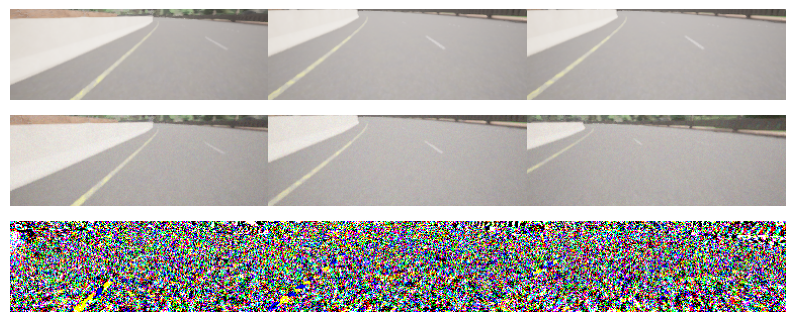

In [12]:
t_image1=test_image[0,:3,:,:].cpu()
t_image2=test_image[0,3:6,:,:].cpu()
t_image3=test_image[0,6:,:,:].cpu()

perturbed_image1=perturbed_image[0,:3,:,:].cpu()
perturbed_image2=perturbed_image[0,3:6,:,:].cpu()
perturbed_image3=perturbed_image[0,6:,:,:].cpu()

noise1=(perturbed_image1-t_image1)*255
noise2=(perturbed_image2-t_image2)*255
noise3=(perturbed_image3-t_image3)*255


plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0, hspace=0.1)  # 그림 사이의 여백을 줄임

plt.subplot(3,3,1)
plt.axis('off')
plt.imshow(t_image1.permute(1,2,0))
plt.subplot(3,3,2)
plt.axis('off')
plt.imshow(t_image2.permute(1,2,0))
plt.subplot(3,3,3)
plt.axis('off')
plt.imshow(t_image2.permute(1,2,0))
plt.subplot(3,3,4)
plt.axis('off')
plt.imshow(perturbed_image1.permute(1,2,0))
plt.subplot(3,3,5)
plt.axis('off')
plt.imshow(perturbed_image2.permute(1,2,0))
plt.subplot(3,3,6)
plt.axis('off')
plt.imshow(perturbed_image3.permute(1,2,0))

plt.subplot(3,3,7)
plt.axis('off')
plt.imshow(noise1.permute(1,2,0))
plt.subplot(3,3,8)
plt.axis('off')
plt.imshow(noise2.permute(1,2,0))
plt.subplot(3,3,9)
plt.axis('off')
plt.imshow(noise3.permute(1,2,0))


+ PSNR

+ SSIM

In [ ]:

psnr_value=calculate_psnr(perturbed_image2.unsqueeze(0),t_image2.unsqueeze(0))
ssim_value=calculate_ssim(perturbed_image2.unsqueeze(0),t_image2.unsqueeze(0))
print("PSNR: ",psnr_value/100)
print("SSIM: ",ssim_value.item())

In [25]:
# np.save('./viewer/GZ_vgg16/vgg16_GZ_original_label.npy',predict_label)

# np.save('./viewer/GI_resnet18/resnet18_GI_PGD8.npy',predict_adv_label)
#np.save('./viewer/GI_resnet18/resnet18_GI_IFGSM8.npy',predict_adv_label)
# np.save('./viewer/GZ_vgg16/vgg16_GZ_opt.npy',predict_adv_label)

# np.save('./viewer/GZ_vgg16/vgg16_GZ_MIFGSM8.npy',predict_adv_label)
np.save('./viewer/GI_resnet18/resnet18_GI_CW.npy',predict_adv_label)

# np.save('./viewer/GZ_vgg16/vgg16_GZ_BPDA.npy',predict_adv_label)

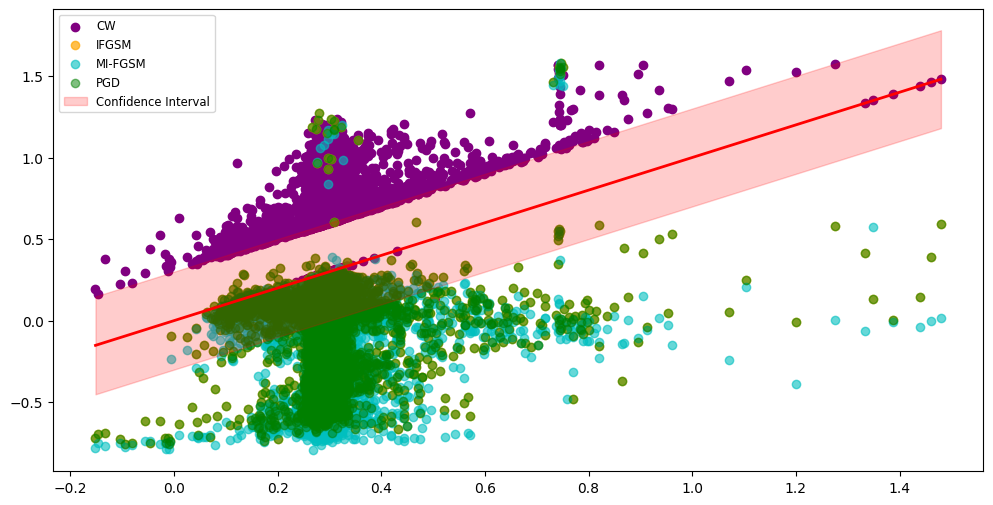

In [4]:
version='FS'
model_name='mobilenet'



pred_ori_label=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_original_label.npy')
pred_FS_PGD8=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_PGD8.npy')
pred_FS_IFGSM8=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_IFGSM8.npy')
# pred_FS_OPT=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_opt.npy')
pred_FS_CW=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_CW.npy')
# pred_FS_BPDA=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_BPDA.npy')
pred_FS_MIFGSM8=np.load('./viewer/'+version+'_'+model_name+'/'+model_name+'_'+version+'_MIFGSM8.npy')
plt.figure(figsize=(12,6))

plt.scatter(pred_ori_label, pred_FS_CW, color='purple', alpha=1.0,label='CW')
# plt.scatter(pred_ori_label, pred_FS_OPT, color='blue', alpha=0.8,label='Optimizer')
plt.scatter(pred_ori_label, pred_FS_IFGSM8, color='orange', alpha=0.7,label='IFGSM')
plt.scatter(pred_ori_label, pred_FS_MIFGSM8, color='c', alpha=0.6,label='MI-FGSM')
plt.scatter(pred_ori_label, pred_FS_PGD8, color='green', alpha=0.5,label='PGD')
# plt.scatter(pred_ori_label, pred_FS_BPDA, color='yellow', alpha=0.4,label='BPDA')
plt.plot([min(pred_ori_label), max(pred_ori_label)], [min(pred_ori_label), max(pred_ori_label)], color='red', linewidth=2)
x_fill = np.linspace(min(pred_ori_label), max(pred_ori_label), 1000)
y_lower = x_fill - 0.3
y_upper = x_fill + 0.3

# plot 길이만큼 채우기
plt.fill_between(x_fill, y_lower, y_upper, color='red', alpha=0.2, label='Confidence Interval')
plt.legend(fontsize='small')
plt.show()
